# RAMSES Nebular Line Emission

Braden Nowicki

Script to visualize RAMSES-RT Simulations of high-redshift galaxies in a variety of metal lines. Ionization Parameter, Number Density, and Temperature for each pixel are input into an interpolator for each line; the interpolator is created via the module 'emission.py'. 'emission.py' currently uses the 'linelist.dat' datatable to build interpolators; this can be adjusted to work with other tables from Cloudy runs. 

In [1]:
# importing packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import emission

import yt
from yt.units import dimensions
import copy

'''
cell_fields = [
    "Density",
    "x-velocity",
    "y-velocity",
    "z-velocity",
    "Pressure",
    "Metallicity",
    # "dark_matter_density",
    "xHI",
    "xHII",
    "xHeII",
    "xHeIII",
]
epf = [
    ("particle_family", "b"),
    ("particle_tag", "b"),
    ("particle_birth_epoch", "d"),
    ("particle_metallicity", "d"),
]
'''

# Cloudy Grid Run Bounds (log values)
# Umin, Umax, Ustep: -6.0 1.0 0.5
# Nmin, Nmax, Nstep: -1.0 6.0 0.5 
# Tmin, Tmax, Tstop: 3.0 6.0 0.1

lines=["H1_6562.80A","O1_1304.86A","O1_6300.30A","O2_3728.80A","O2_3726.10A","O3_1660.81A",
       "O3_1666.15A","O3_4363.21A","O3_4958.91A","O3_5006.84A", "He2_1640.41A","C2_1335.66A",
       "C3_1906.68A","C3_1908.73A","C4_1549.00A","Mg2_2795.53A","Mg2_2802.71A","Ne3_3868.76A",
       "Ne3_3967.47A","N5_1238.82A","N5_1242.80A","N4_1486.50A","N3_1749.67A","S2_6716.44A","S2_6730.82A"]

# Ionization Parameter Field
# Based on photon densities bins 1-4
# Should not include bin 1 -> Lyman Werner non-ionizing
# TODO check ionization parameter
def _ion_param(field, data): 
    from yt.frontends.ramses.field_handlers import RTFieldFileHandler
    p = RTFieldFileHandler.get_rt_parameters(ds).copy()
    p.update(ds.parameters)

    cgs_c =  2.99792458e10     #light velocity
    pd_2 = data['ramses-rt','Photon_density_2']*p["unit_pf"]/cgs_c #physical photon number density in cm-3
    pd_3 = data['ramses-rt','Photon_density_3']*p["unit_pf"]/cgs_c
    pd_4 = data['ramses-rt','Photon_density_4']*p["unit_pf"]/cgs_c

    photon = pd_2 + pd_3 + pd_4

    return photon/data['gas', 'number_density']  

# Temporarily testing rt fields
def _ion_param2(field, data): 
    from yt.frontends.ramses.field_handlers import RTFieldFileHandler
    p = RTFieldFileHandler.get_rt_parameters(ds).copy()
    p.update(ds.parameters)

    cgs_c =  2.99792458e10     #light velocity
    pd_2 = data['rt','photon_density_2']#*p["unit_pf"]/cgs_c #physical photon number density in cm-3
    pd_3 = data['rt','photon_density_3']#*p["unit_pf"]/cgs_c
    pd_4 = data['rt','photon_density_4']#*p["unit_pf"]/cgs_c

    photon = pd_2 + pd_3 + pd_4

    return photon/data['gas', 'number_density']*data['gas', 'number_density']/data['gas', 'number_density']

yt.add_field(
    ('gas', 'ion-param'), 
    function=_ion_param, 
    sampling_type="cell", 
    units="cm**3", 
    force_override=True
)

yt.add_field(
    ('gas', 'ion-param2'), 
    function=_ion_param2, 
    sampling_type="cell", 
    units="1", 
    force_override=True
)

# True divides emissions by density squared in interpolator
dens_normalized = False
if dens_normalized: 
    units = '1/cm**3'
else:
    units = '1'

# Add intensity fields for all lines in the list
for i in range(len(lines)):
    yt.add_field(
        #('gas', 'intensity_' + lines[i] + '_[erg_cm^{-2}_s^{-1}]'),
        ('gas', 'intensity_' + lines[i]),
        function=emission.get_line_emission(i, dens_normalized),
        sampling_type='cell',
        units=units,
        force_override=True
    )

f1 = "/Users/bnowicki/Documents/Research/Ricotti/output_00273"

ds = yt.load(f1)
ad = ds.all_data()

ds.fields

-6.0 1.0 0.5 -1.0 6.0 0.5 3.0 6.0 0.1
(25, 6975)
15 15 31


yt : [INFO     ] 2024-10-27 13:03:59,482 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2024-10-27 13:03:59,483 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-10-27 13:03:59,483 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-27 13:03:59,483 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-27 13:03:59,483 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-27 13:03:59,484 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2024-10-27 13:03:59,484 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2024-10-27 13:03:59,484 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2024-10-27 13:03:59,485 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-10-27 13:03:59,485 Parameters: hubble_constant           = 0.674000015258789
yt : [INFO     ] 2024-10-27 13:03:59,491 Detected RAMSES-RT 

## Visualizing Simulation Parameters Ionization Parameter, Density, Temperature

In [ ]:
# TODO
# gas metallicity in solar or not? divide by 0.02?

In [2]:
# For projections in a spherical region
sp = ds.sphere([0.49118094, 0.49275361, 0.49473726], (700, "pc"))

yt : [INFO     ] 2024-10-27 13:04:20,533 Projection completed
yt : [INFO     ] 2024-10-27 13:04:20,535 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:04:20,535 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:04:20,536 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:04:20,536 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:04:20,538 Making a fixed resolution buffer of (('gas', 'ion-param')) 1000 by 1000



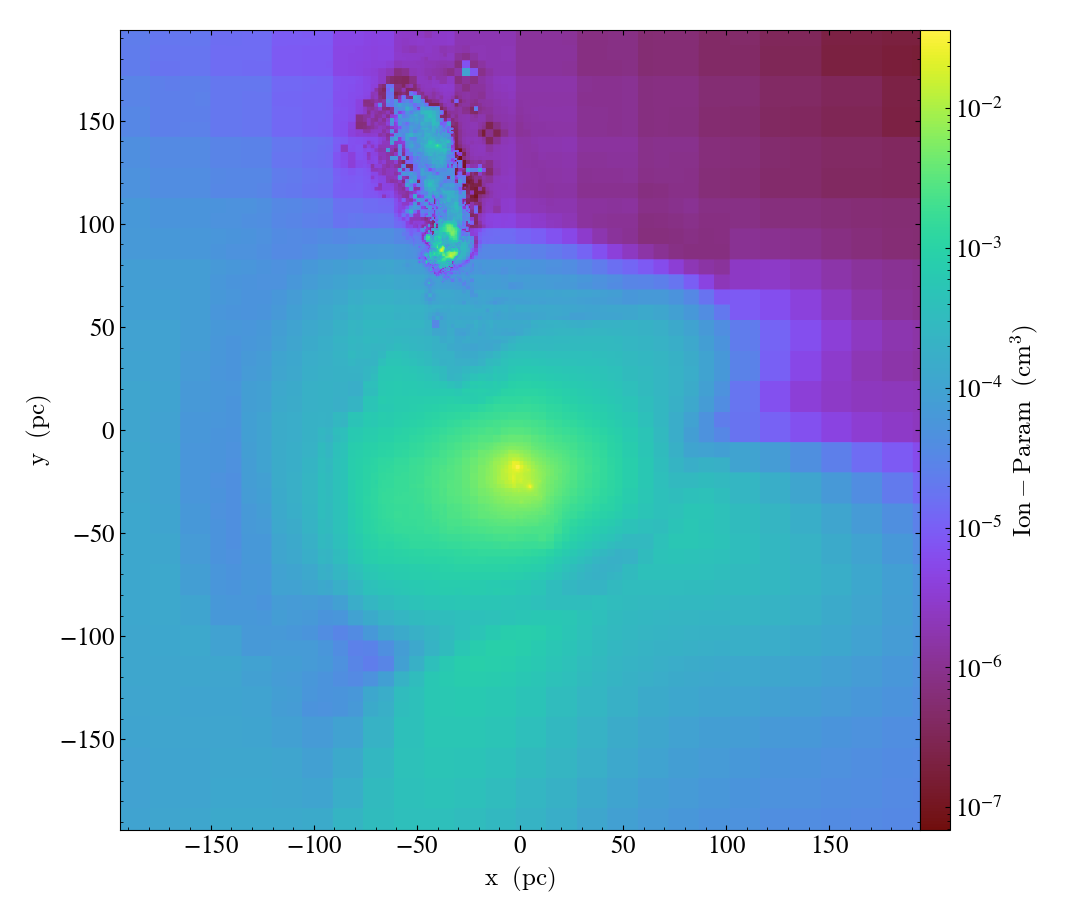

In [3]:
# Ionization Parameter
p = yt.ProjectionPlot(ds, "z", ("gas", "ion-param"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-27 12:56:25,312 Projection completed
yt : [INFO     ] 2024-10-27 12:56:25,313 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:56:25,313 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:56:25,315 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:56:25,315 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:56:25,316 Making a fixed resolution buffer of (('gas', 'ion-param2')) 1000 by 1000



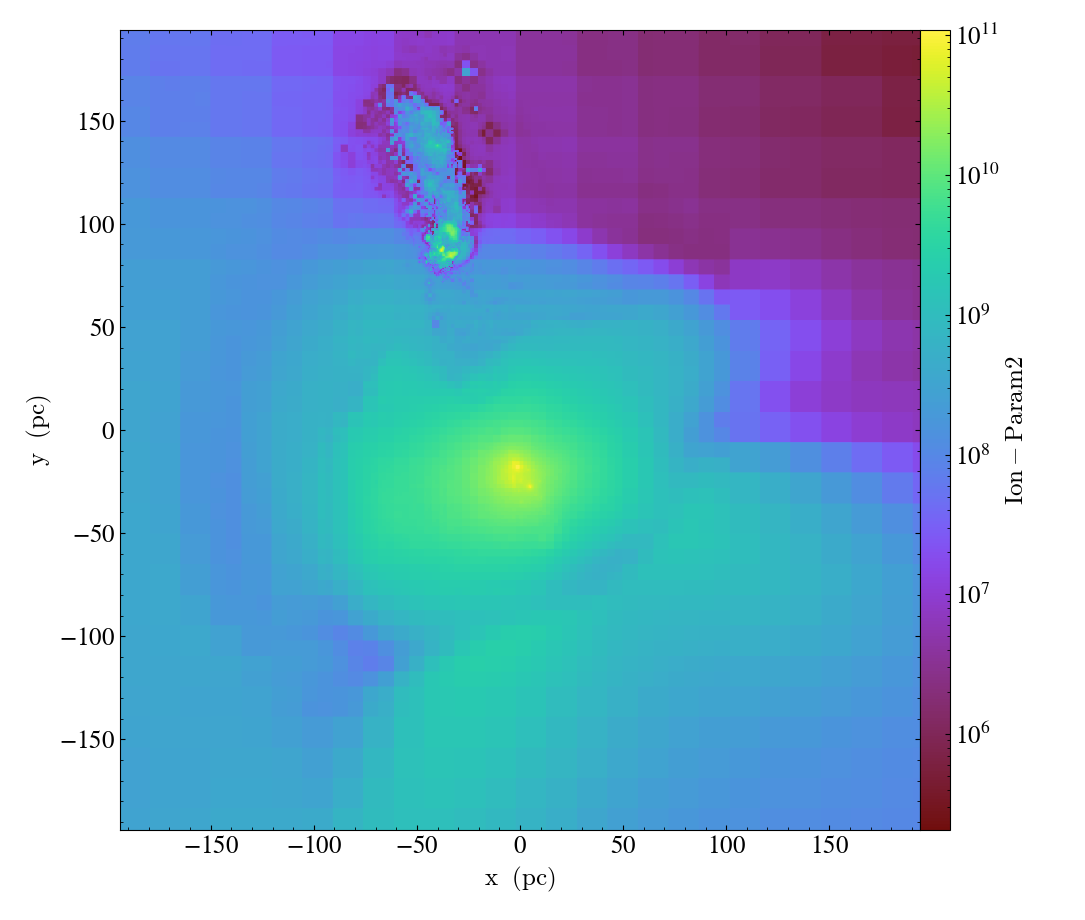

In [29]:
# Ionization Parameter
p = yt.ProjectionPlot(ds, "z", ("gas", "ion-param2"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

In [30]:
r = ad['gas', 'ion-param']/ad['gas', 'ion-param2']

In [11]:
print(min(r), max(r))

3.335640951981503e-13 cm**3 3.335640951981507e-13 cm**3


yt : [INFO     ] 2024-10-27 12:58:33,830 Projection completed
yt : [INFO     ] 2024-10-27 12:58:33,831 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:33,831 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:33,832 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:33,832 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:33,833 Making a fixed resolution buffer of (('gas', 'number_density')) 1000 by 1000



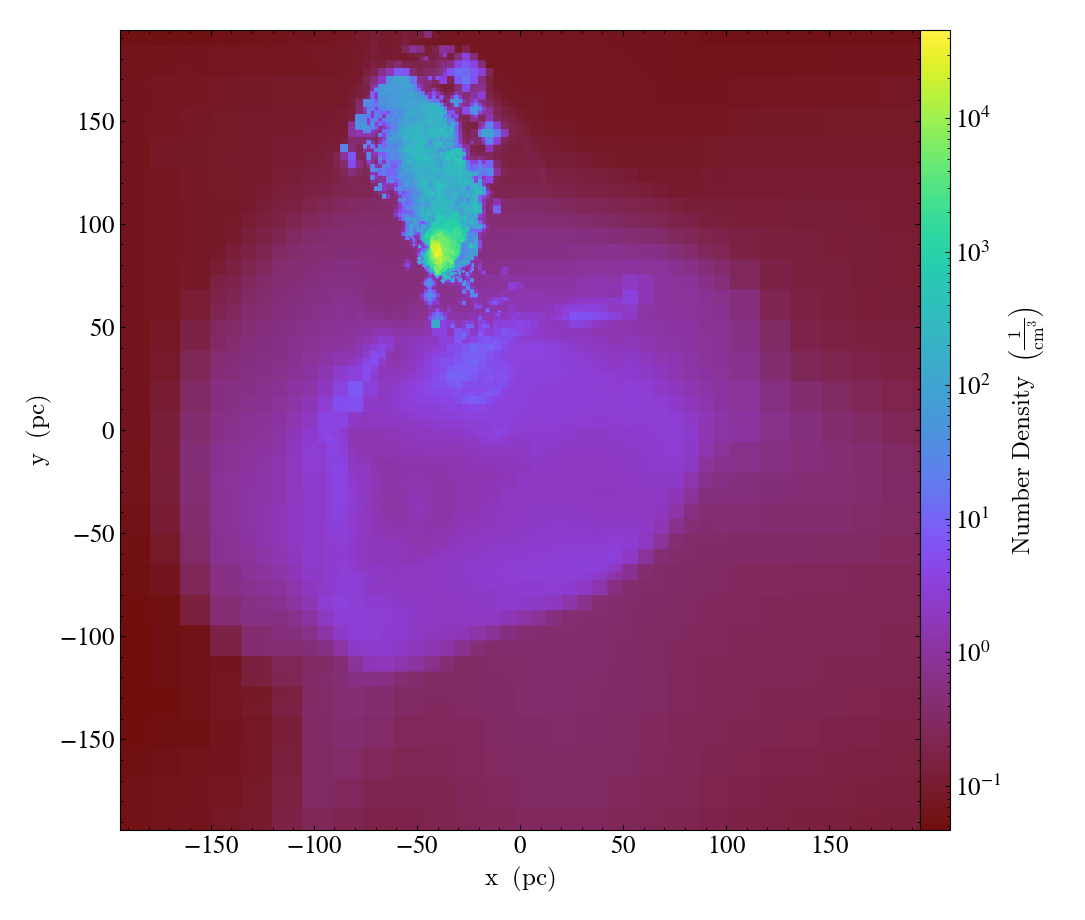

In [31]:
# Number Density
p = yt.ProjectionPlot(ds, "z", ("gas", "number_density"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-27 12:58:38,174 Projection completed
yt : [INFO     ] 2024-10-27 12:58:38,175 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:38,175 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:38,177 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:38,177 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:38,178 Making a fixed resolution buffer of (('gas', 'density')) 1000 by 1000



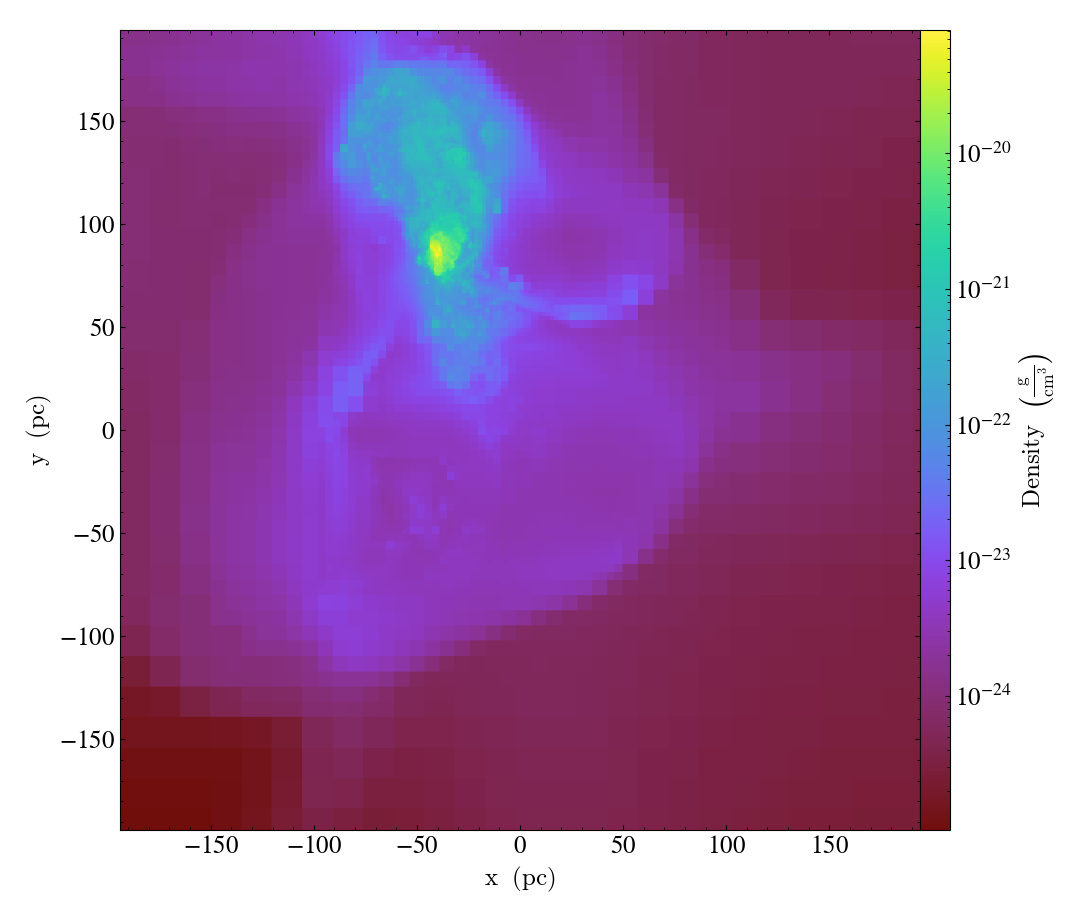

In [32]:
# Mass Density
p = yt.ProjectionPlot(ds, "z", ("gas", "density"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-27 12:58:42,586 Projection completed
yt : [INFO     ] 2024-10-27 12:58:42,587 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:42,587 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:42,588 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:42,589 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:42,589 Making a fixed resolution buffer of (('gas', 'temperature')) 1000 by 1000



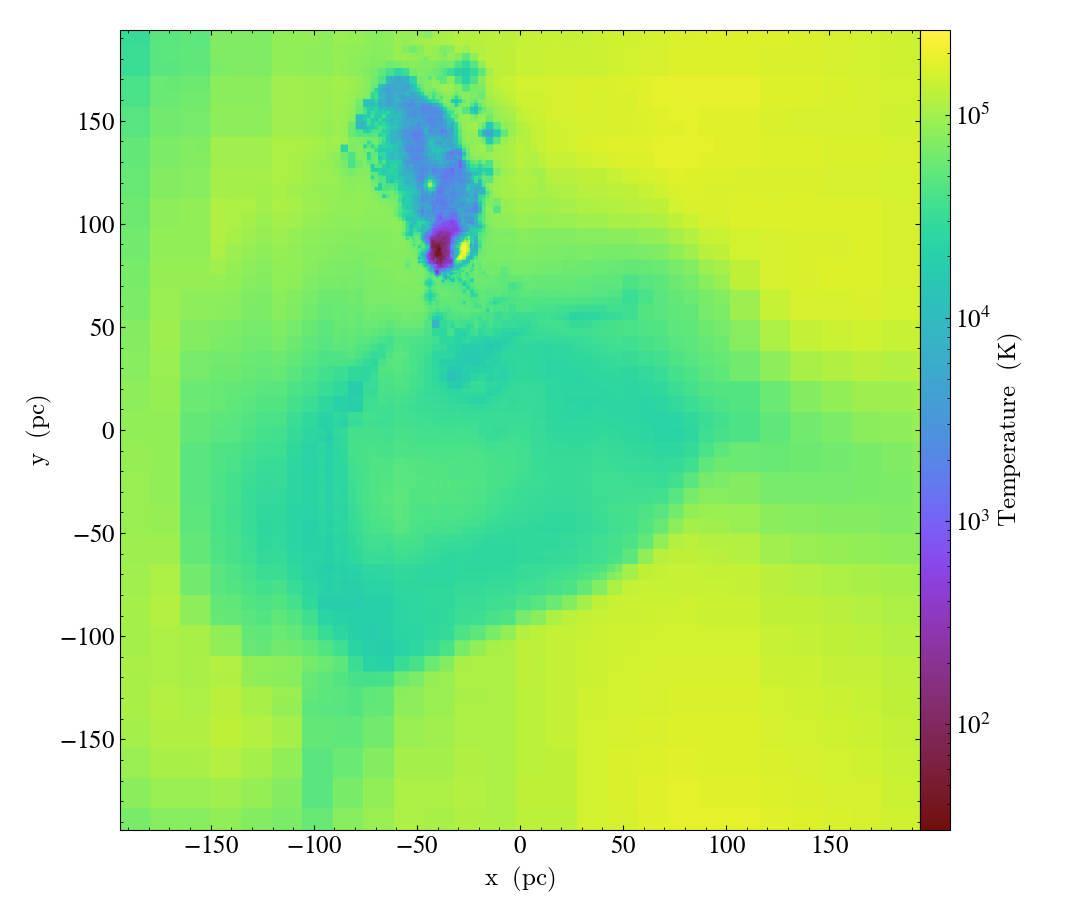

In [33]:
# Temperature
p = yt.ProjectionPlot(ds, "z", ("gas", "temperature"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-27 12:58:47,671 Projection completed
yt : [INFO     ] 2024-10-27 12:58:47,671 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:47,671 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:47,672 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:47,673 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:47,673 Making a fixed resolution buffer of (('gas', 'metallicity')) 1000 by 1000



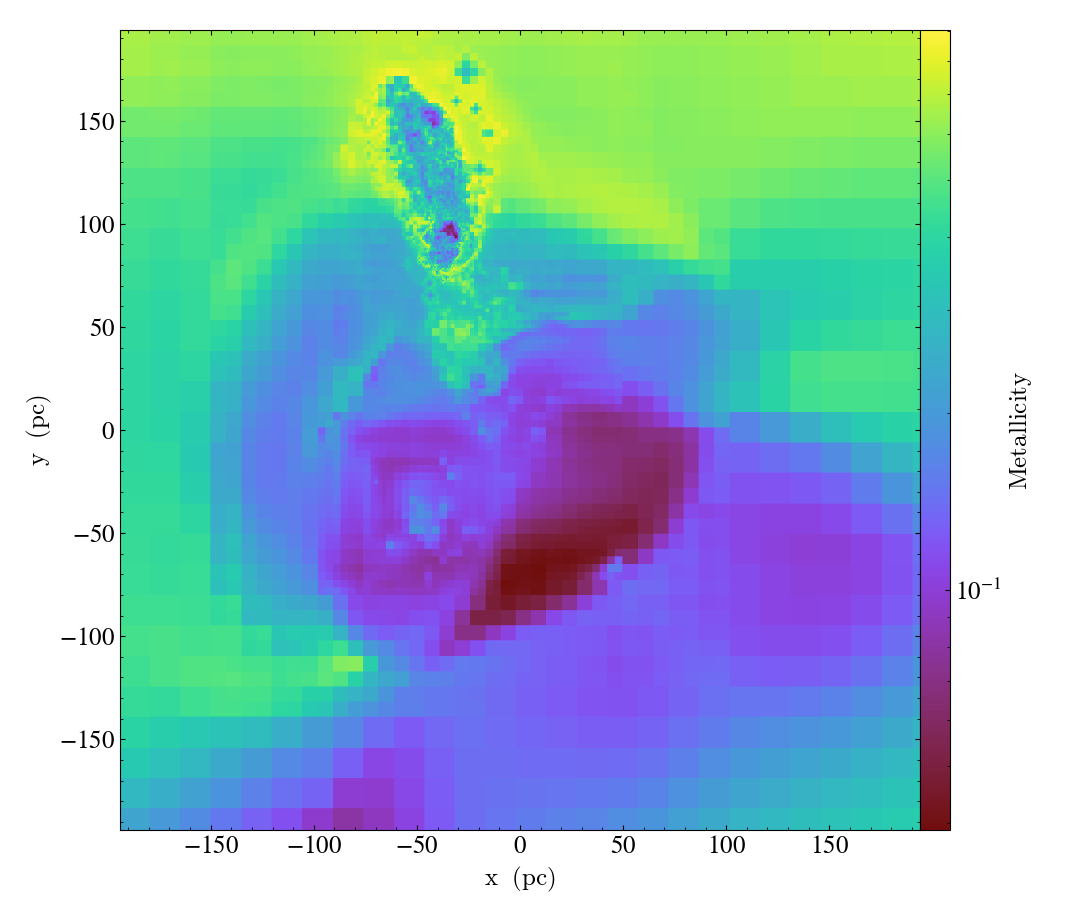

In [34]:
# Metallicity
p = yt.ProjectionPlot(ds, "z", ("gas", "metallicity"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

## Visualizing Line Intensities

yt : [INFO     ] 2024-10-27 13:04:33,433 Projection completed
yt : [INFO     ] 2024-10-27 13:04:33,433 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:04:33,433 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:04:33,435 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:04:33,435 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:04:33,435 Making a fixed resolution buffer of (('gas', 'intensity_H1_6562.80A')) 1000 by 1000



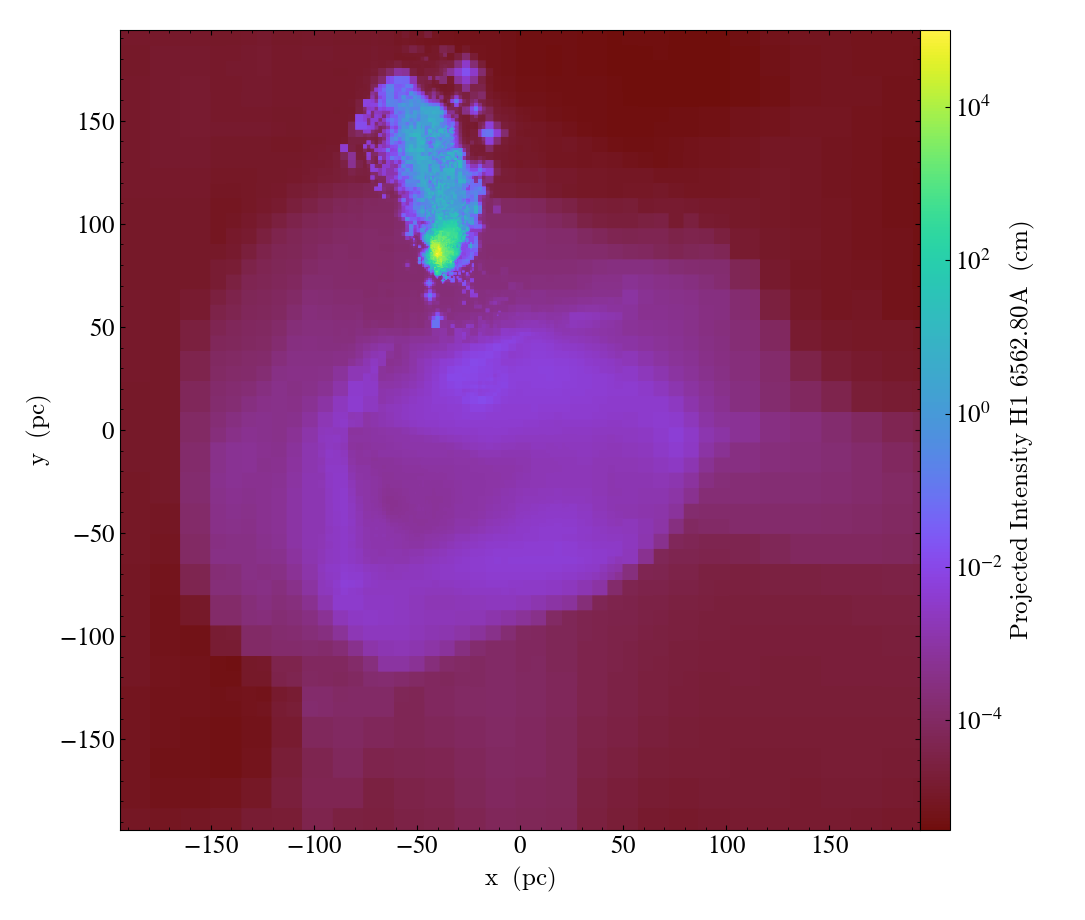

In [4]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_H1_6562.80A"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-27 13:04:39,173 Projection completed
yt : [INFO     ] 2024-10-27 13:04:39,173 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:04:39,173 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:04:39,175 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:04:39,175 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:04:39,176 Making a fixed resolution buffer of (('gas', 'intensity_O3_5006.84A')) 1000 by 1000



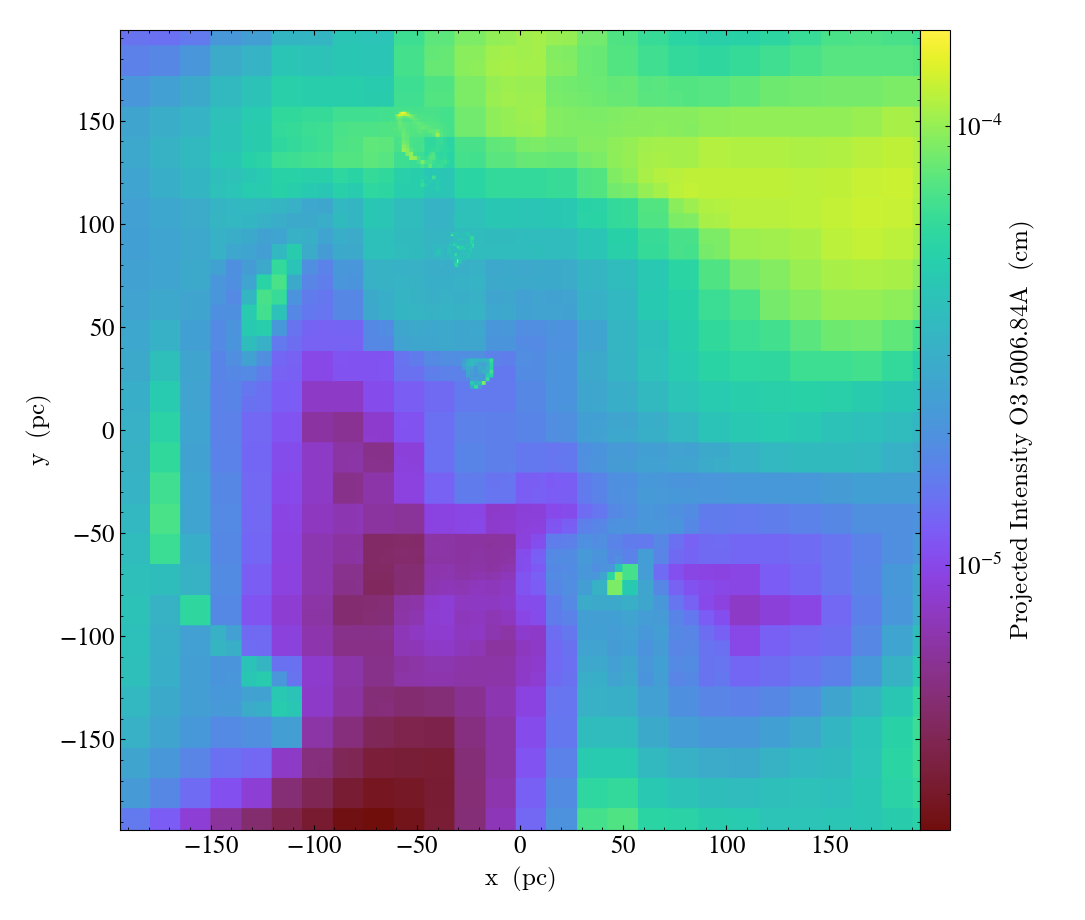

In [5]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O3_5006.84A"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-27 13:01:11,958 Projection completed
yt : [INFO     ] 2024-10-27 13:01:11,959 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:01:11,959 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:01:11,960 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:01:11,961 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:01:11,961 Making a fixed resolution buffer of (('gas', 'intensity_He2_1640.41A')) 1000 by 1000



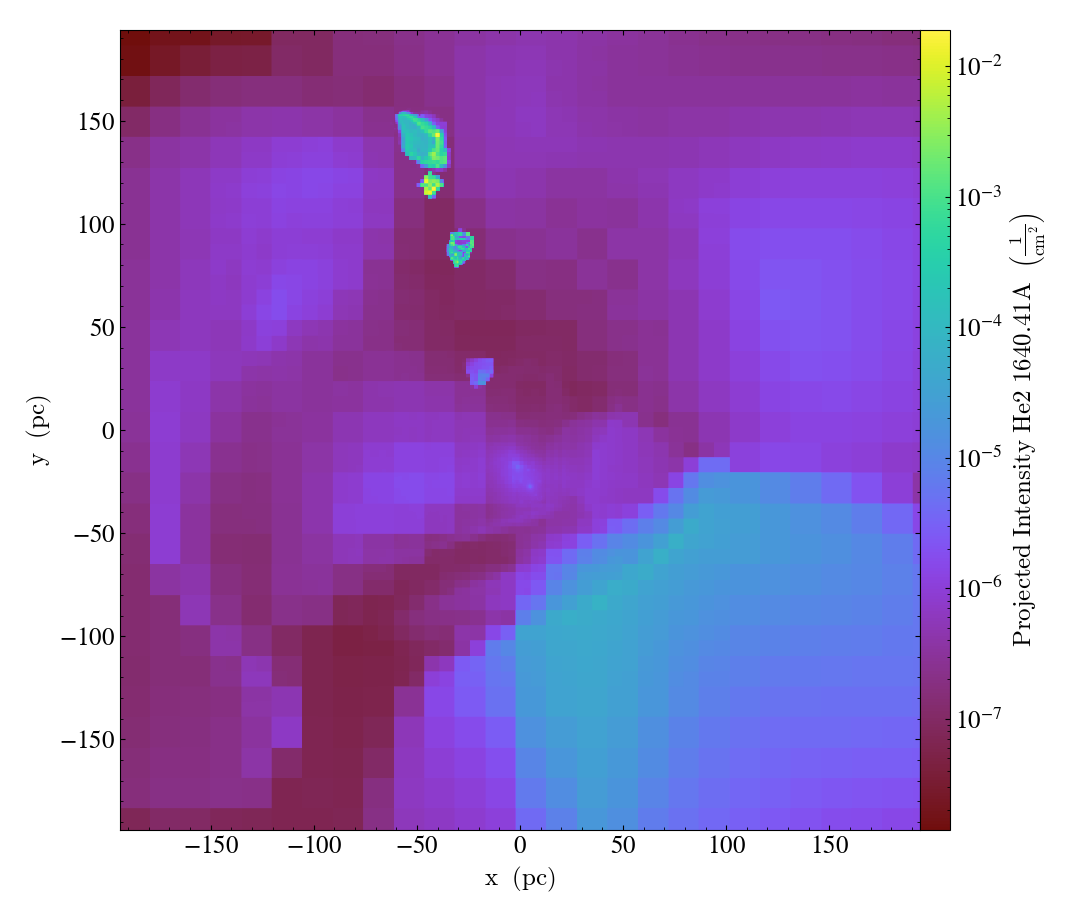

In [42]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_He2_1640.41A"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

## OII Ratio

### Calculate OII Ratio at each Pixel then Project

yt : [INFO     ] 2024-10-27 13:01:20,959 Projection completed
yt : [INFO     ] 2024-10-27 13:01:20,960 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:01:20,960 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:01:20,962 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:01:20,962 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:01:20,963 Making a fixed resolution buffer of (('gas', 'intensity_O2_3728.80A')) 1000 by 1000



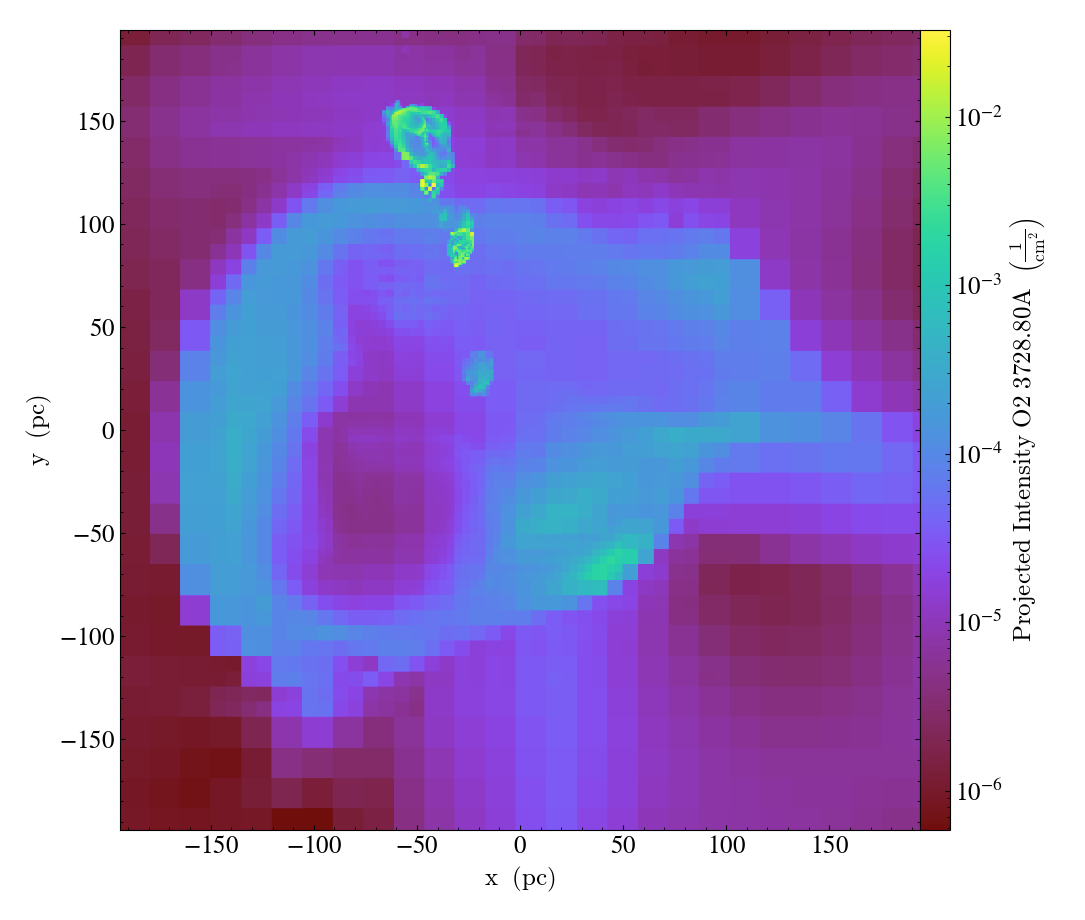

In [43]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O2_3728.80A"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

In [44]:
# Ratio between two OII line emissions acts as an observational diagnostic
# of electron density
def _OII_ratio(field, data):
    return data["intensity_O2_3728.80A"]/data["intensity_O2_3726.10A"]

ds.add_field(
    ('gas', 'OII_ratio'),
    function=_OII_ratio,
    sampling_type='cell',
    units='1',
    force_override=True
)

/Users/bnowicki/Documents/GitHub/NebularLines/emission.py:95: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(T_val)
yt : [INFO     ] 2024-10-27 13:01:40,679 Projection completed
yt : [INFO     ] 2024-10-27 13:01:40,681 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:01:40,682 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:01:40,684 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 13:01:40,684 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 13:01:40,685 Making a fixed resolution buffer of (('gas', 'OII_ratio')) 1000 by 1000



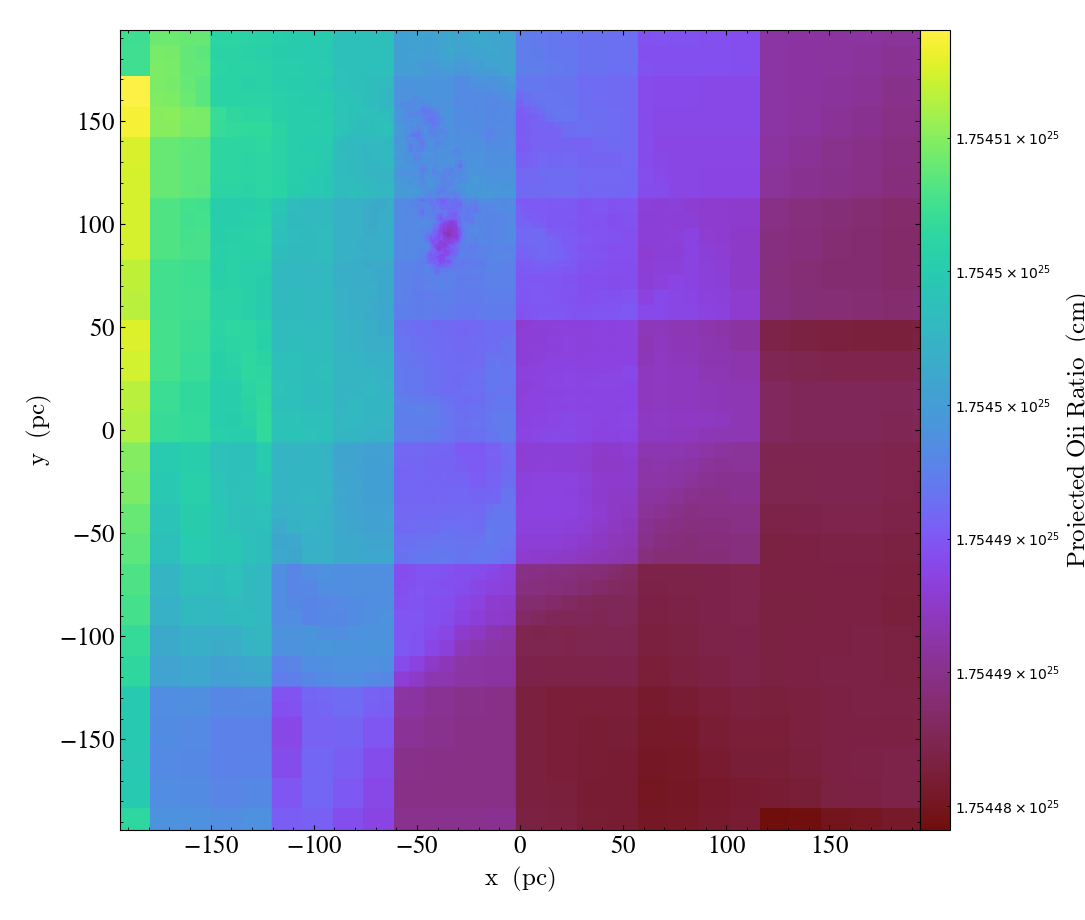

In [45]:
p = yt.ProjectionPlot(ds, "z", ("gas", "OII_ratio"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      #data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

p.show()

yt : [INFO     ] 2024-10-16 23:04:08,245 Projection completed
yt : [INFO     ] 2024-10-16 23:04:08,248 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:04:08,248 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 23:04:08,250 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:04:08,251 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 23:04:08,252 Making a fixed resolution buffer of (('gas', 'H_p1_fraction')) 1000 by 1000



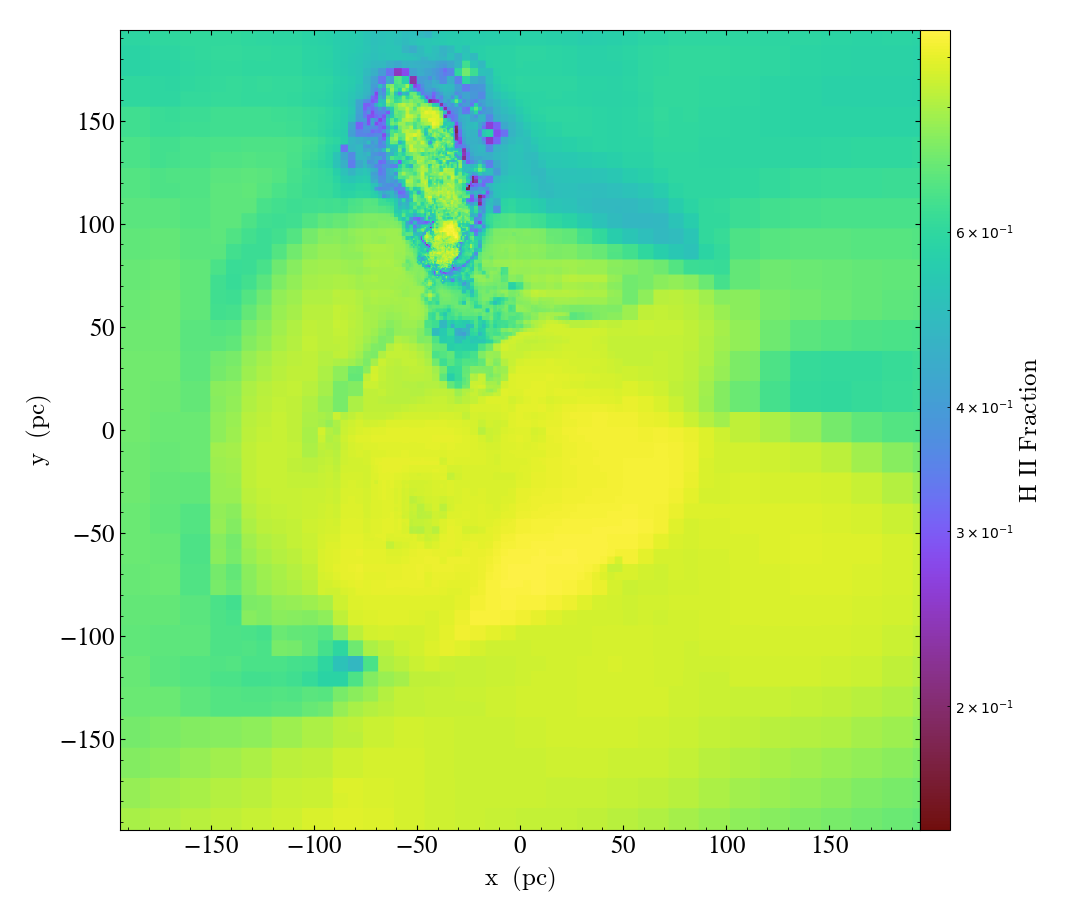

In [8]:
p = yt.ProjectionPlot(ds, "z", ("gas", "H_p1_fraction"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

p.show()

### Alternatively, Project both OII emission lines then calculate ratio

/Users/bnowicki/Documents/GitHub/NebularLines/emission.py:95: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(T_val)
yt : [INFO     ] 2024-10-24 16:11:47,627 Projection completed
yt : [INFO     ] 2024-10-24 16:11:47,630 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-24 16:11:47,630 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-24 16:11:47,632 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-24 16:11:47,632 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-24 16:11:47,633 Making a fixed resolution buffer of (('gas', 'intensity_O2_3728.80A')) 1000 by 1000
yt : [INFO     ] 2024-10-24 16:11:58,683 Projection completed
yt : [INFO     ] 2024-10-24 16:11:58,683 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-24 16:11:58,683 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-24 16:11:58,684 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-24 16:11:58,685 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-24 16:11:58,686 Making a fixed resolution buffer of (('gas', '


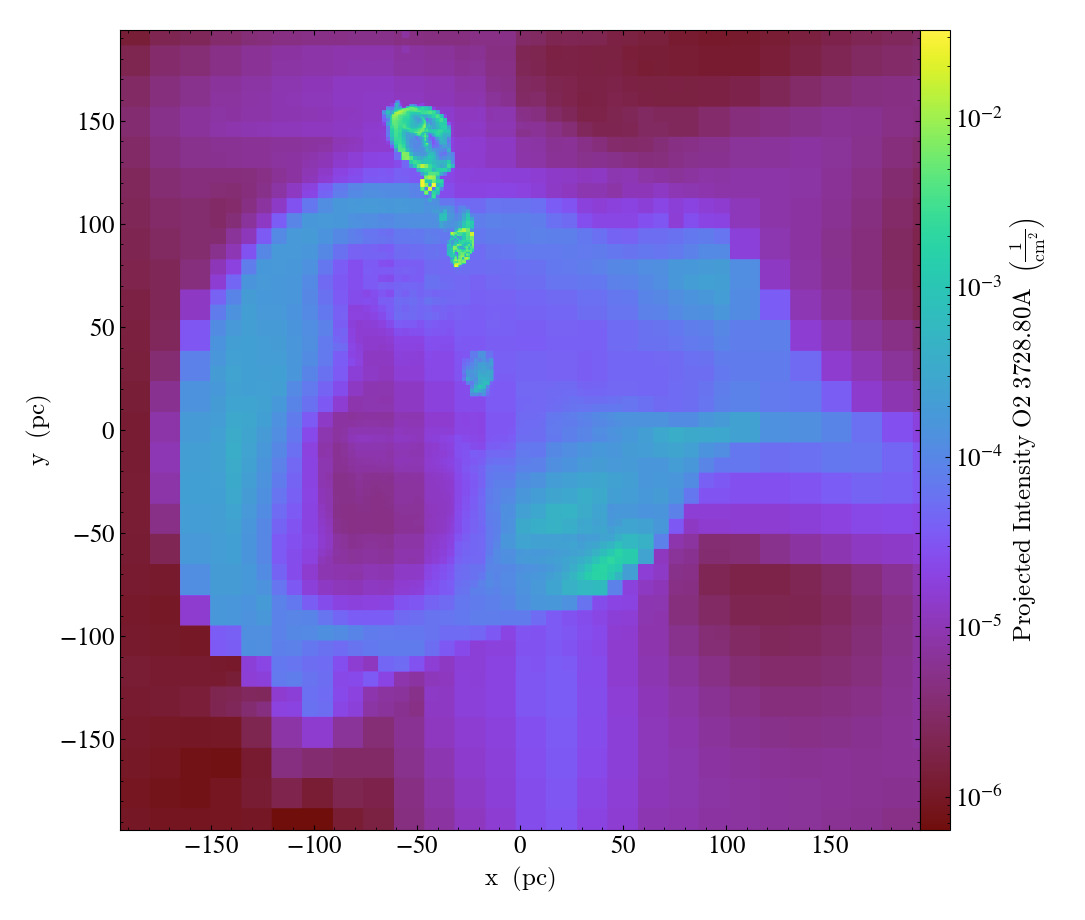


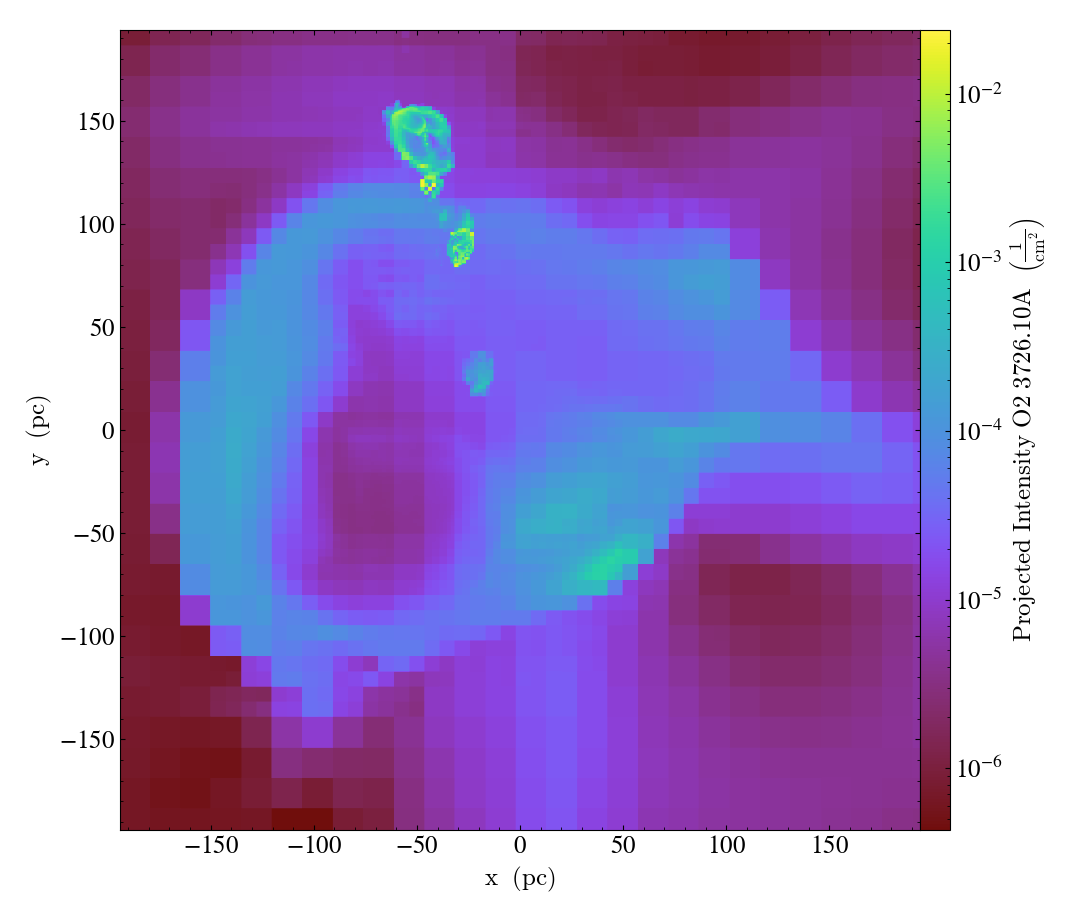

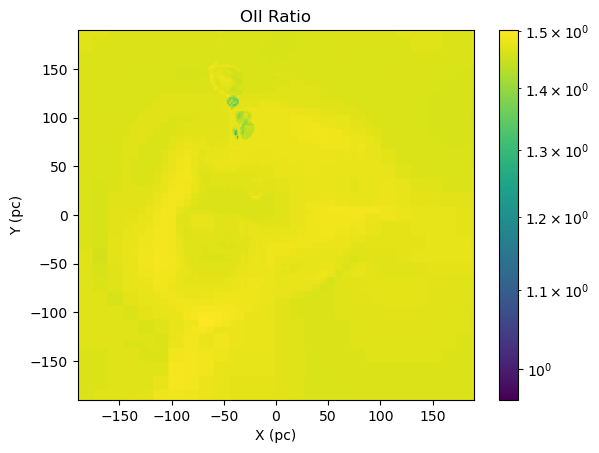

In [22]:
from matplotlib.colors import LogNorm

# Define the center for the projection
center = [0.49118094, 0.49275361, 0.49473726]

# Create Projection Plots
p1 = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O2_3728.80A"), width=0.0001,
                      #weight_field=("gas", "number_density"), 
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=center)

p2 = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O2_3726.10A"), width=0.0001,
                      #weight_field=("gas", "number_density"), 
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=center)

p1.show()
p2.show()

# Fixed-Resolution Buffer from the projection
p1_frb = p1.frb  
p2_frb = p2.frb
p1_img = np.array(p1_frb["gas", "intensity_O2_3728.80A"])
p2_img = np.array(p2_frb["gas", "intensity_O2_3726.10A"])
ratio = p1_img/p2_img

# Calculate limits for the plot
lbox = 380  # in pc
extent_dens = [-lbox/2, lbox/2, -lbox/2, lbox/2]
dens_norm = LogNorm(np.min(ratio), np.max(ratio))
# Ensure the aspect ratio of the image matches the scatter plot
plt.imshow(ratio, norm=dens_norm, extent=extent_dens, origin='lower', aspect='auto')
plt.xlabel("X (pc)")
plt.ylabel("Y (pc)")
plt.title("OII Ratio")
plt.xlim(-lbox/2, lbox/2)
plt.ylim(-lbox/2, lbox/2)
plt.colorbar()
plt.show()



In [25]:
print(np.min(ratio))

0.9640399169397919


## Slice Plots

yt : [INFO     ] 2024-10-16 23:24:51,678 max value is 1.39742e+05 at 0.4911709129810333 0.4927761256694794 0.4947503507137299
yt : [INFO     ] 2024-10-16 23:24:52,934 xlim = 0.491126 0.491216
yt : [INFO     ] 2024-10-16 23:24:52,935 ylim = 0.492731 0.492821
yt : [INFO     ] 2024-10-16 23:24:52,936 xlim = 0.491126 0.491216
yt : [INFO     ] 2024-10-16 23:24:52,936 ylim = 0.492731 0.492821
yt : [INFO     ] 2024-10-16 23:24:52,937 Making a fixed resolution buffer of (('gas', 'number_density')) 1000 by 1000



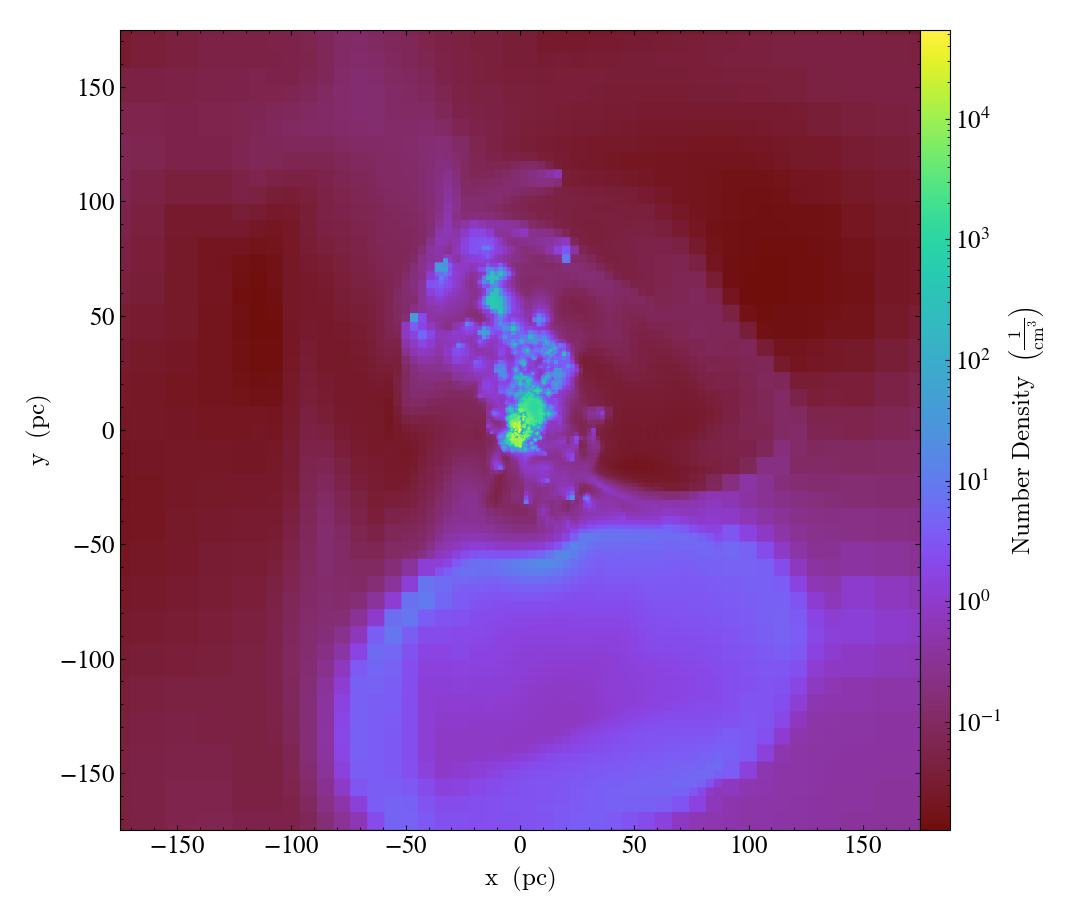

In [19]:
slc = yt.SlicePlot(
    ds,
    "z",
    ("gas", "number_density"),
    #center=[0.49118094, 0.49275361, 0.49473726],
    center=("max", ("gas", "number_density")),
    width=(350, "pc"),
    buff_size=(1000, 1000),
)

#slc.save()
slc.show()

In [63]:
print(ad.quantities.max_location(("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]")))
print(ad.quantities.max_location(("gas", "density")))

/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_89127/1815844088.py:63: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)


[unyt_quantity(8.67997483e-15, '(dimensionless)'), unyt_quantity(0.49117072, 'code_length'), unyt_quantity(0.49277569, 'code_length'), unyt_quantity(0.49474852, 'code_length')]
[unyt_quantity(2.75715809e-19, 'g/cm**3'), unyt_quantity(0.49117097, 'code_length'), unyt_quantity(0.49277607, 'code_length'), unyt_quantity(0.49475041, 'code_length')]


/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_89127/3069468269.py:63: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)
yt : [INFO     ] 2024-10-17 16:25:24,532 xlim = 0.491136 0.491226
yt : [INFO     ] 2024-10-17 16:25:24,533 ylim = 0.492708 0.492799
yt : [INFO     ] 2024-10-17 16:25:24,534 xlim = 0.491136 0.491226
yt : [INFO     ] 2024-10-17 16:25:24,535 ylim = 0.492708 0.492799
yt : [INFO     ] 2024-10-17 16:25:24,536 Making a fixed resolution buffer of (('gas', 'intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]')) 1000 by 1000



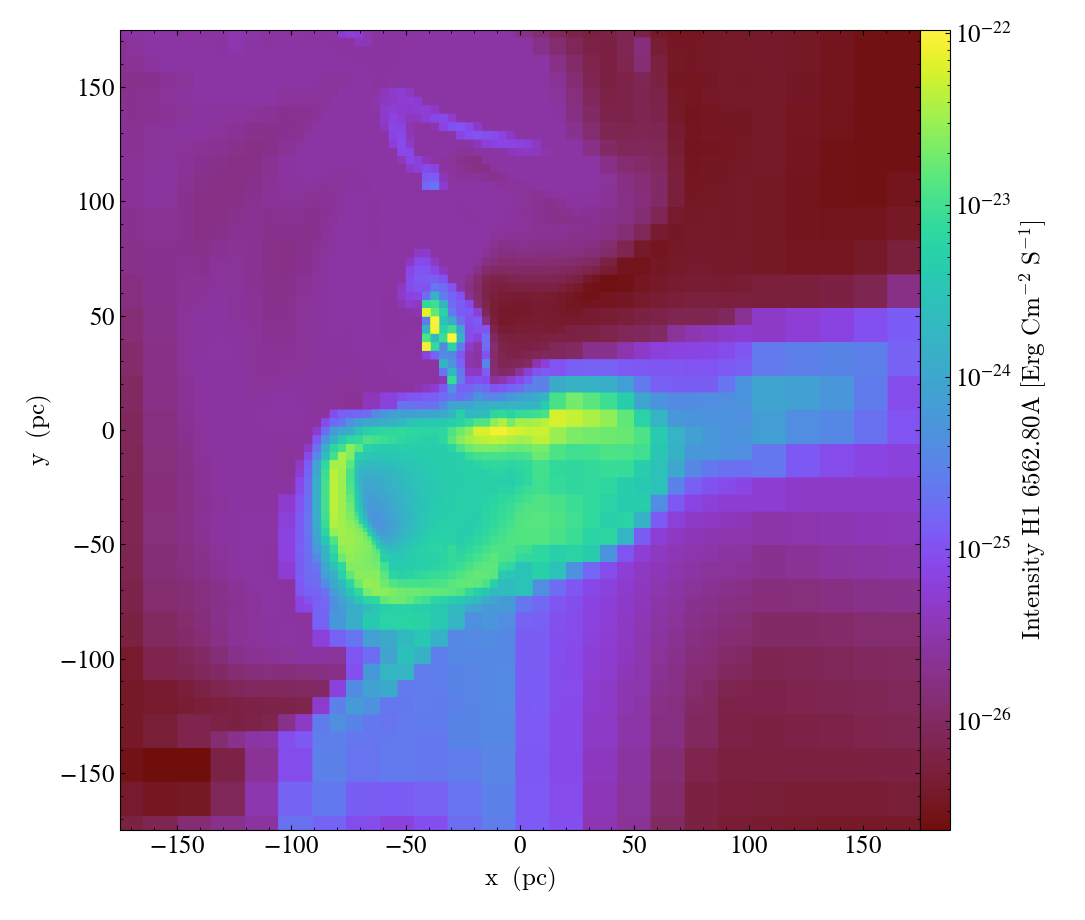

In [61]:
slc = yt.SlicePlot(
    ds,
    "z",
    ("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]"),
    center=[0.49118094, 0.49275361, 0.49473726],
    #center=("max", ("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]")),
    width=(350, "pc"),
    buff_size=(1000, 1000),
)

#slc.save()
slc.show()